# Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from eda.chart_utils import plot_categorical_variable
from feat.feature_builder import FeatureHandler

import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Data import

In [10]:
customers = pd.read_csv("/workspaces/new_bpp/data/customer_data.csv")
trans = pd.read_csv("/workspaces/new_bpp/data/transactions_data.csv")
trans["Date"] = [datetime.datetime.strptime(date_, '%Y-%m-%d') for date_ in trans["Date"]]

* The data of transations is free of missing values.
* The data of customers has missing values in education and for those users without loyalty card there is not information in Loyalty Points.

In [11]:
trans.head(3)

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0


* it is possible to compute percentage of completed transactions for each user

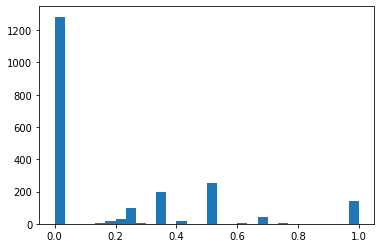

In [12]:
num_intrans = trans.loc[:,["Customer ID", "Incomplete Transaction"]].groupby("Customer ID").sum()
num_trans = trans.loc[:,["Customer ID", "Incomplete Transaction"]].groupby("Customer ID").count()
c = (num_intrans/num_trans)
cc = customers.merge(c, on="Customer ID")
cc = cc.merge(num_intrans, on="Customer ID")
cc = cc.merge(num_trans, on="Customer ID")

plt.hist(cc["Incomplete Transaction_x"], bins=30)
plt.show()


In [13]:
customers.head(3)

,Customer ID,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,CID_7225,63,Female,Urban,Married,High School,68000.0,1,6.0
1,CID_10008,49,Male,Urban,Divorced,Graduate,62500.0,1,4.0
2,CID_6297,51,Female,Suburban,Widowed,Graduate,58500.0,0,NaN


In [14]:
complete_df = trans.merge(customers, on="Customer ID")


In [15]:
complete_df.head(3)

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0,19,Female,Rural,Divorced,High School,21000.0,0,NaN
1,TRID_85235,CID_12160,2020-01-08,8,4,14.88,8.90,6.32,12,0,19,Female,Rural,Divorced,High School,21000.0,0,NaN
2,TRID_17033,CID_12160,2020-01-05,7,2,9.36,5.37,2.67,6,0,19,Female,Rural,Divorced,High School,21000.0,0,NaN


In [16]:
vh = FeatureHandler(complete_df)
vh.run_feat_buider()

# Transaction variables
### Univariant transaction variables study

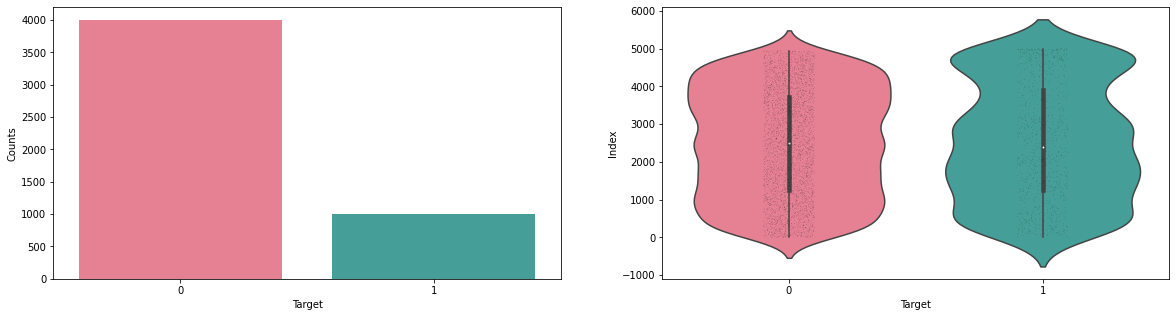

In [17]:
plot_categorical_variable(vh.df["Incomplete Transaction"].values, complete_df.index.values)

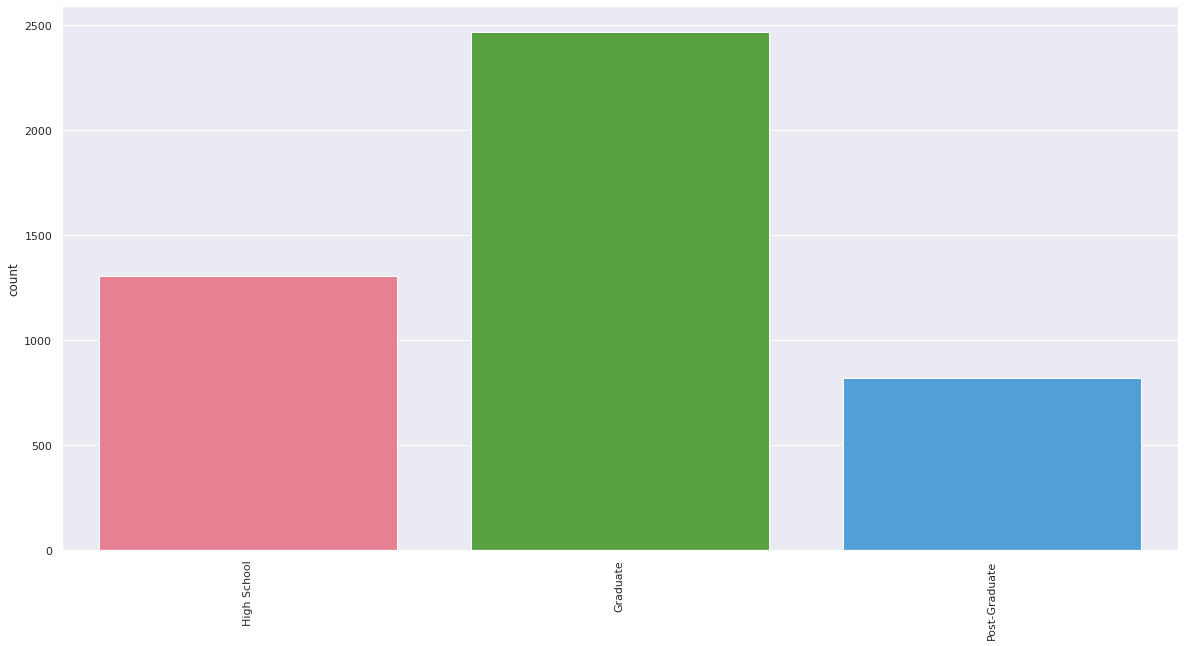

In [18]:
plot_categorical_variable(complete_df["Education"].values, trans.index.values, violin=False)

In [19]:
variable = "Education"
count_val = complete_df.loc[:,[variable, "Incomplete Transaction","Region"]].groupby([variable]).count()
sum_val = complete_df.loc[:,[variable, "Incomplete Transaction","Region"]].groupby([variable]).sum()
print(count_val)
sum_val/count_val

               Incomplete Transaction  Region
Education                                    
Graduate                         2467    2467
High School                      1308    1308
Post-Graduate                     818     818


,Incomplete Transaction,Region
Education,,
Graduate,0.213620,NaN
High School,0.164373,NaN
Post-Graduate,0.204156,NaN


# Multivariate transaction variables study 

In [20]:
df_numeric = vh.df.iloc[:,3:].select_dtypes(include=['number']).drop(columns=['Incomplete Transaction'])
distribution_cols = []
distribution_cols += [x for x in df_numeric.columns]


<function matplotlib.pyplot.show(close=None, block=None)>

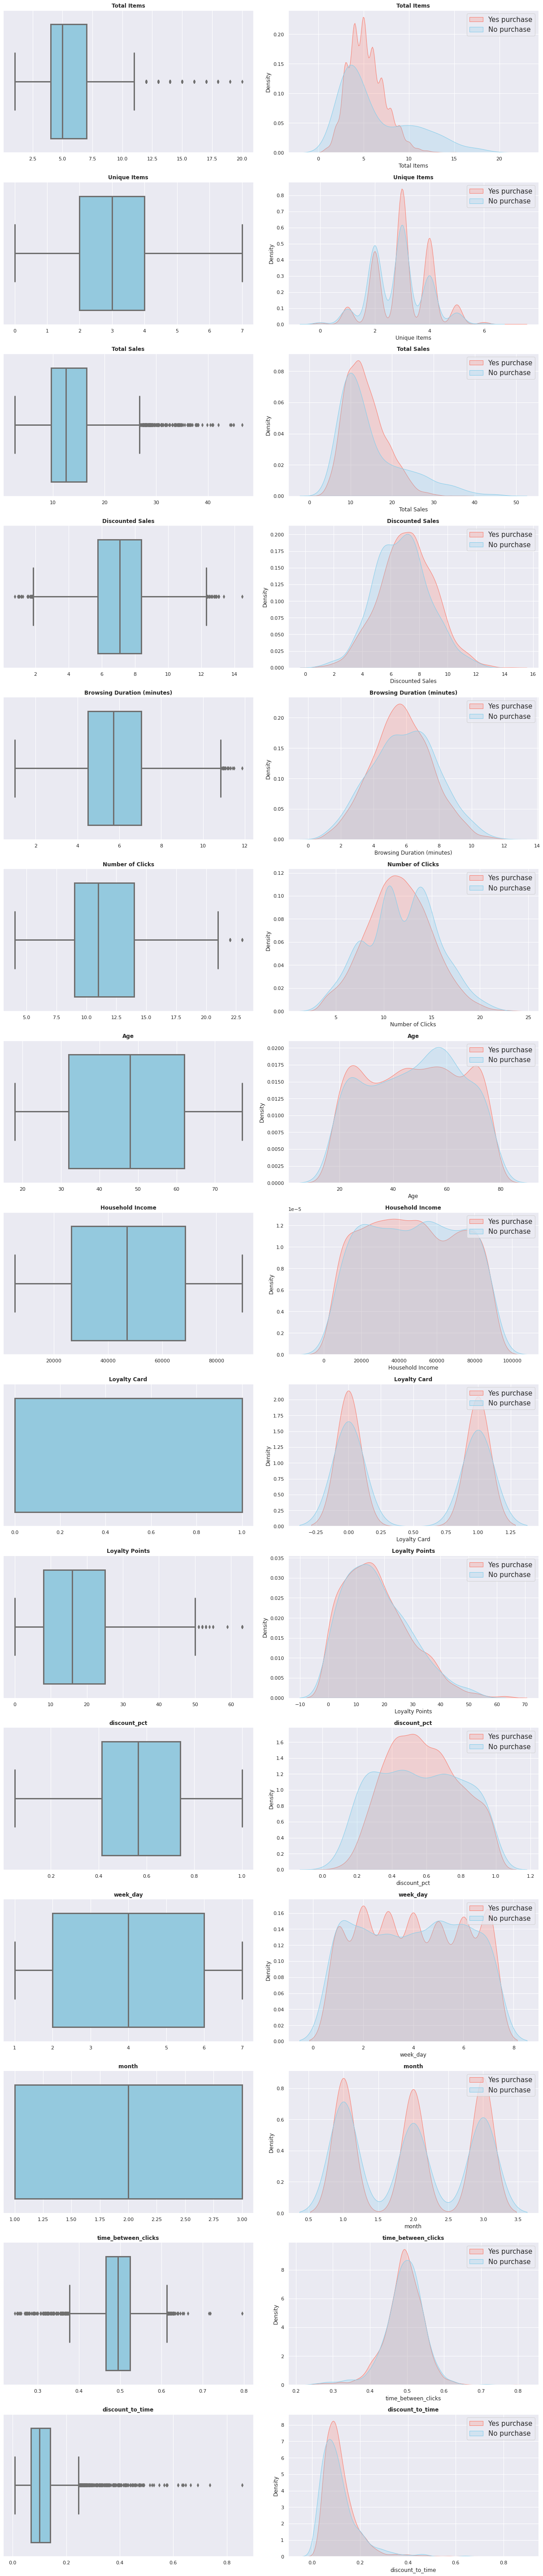

In [21]:
fig = plt.figure(figsize=(17, 80))
i = 1
for col in distribution_cols:
    ax = fig.add_subplot(df_numeric.shape[1], 2, i)
    #violin = sns.violinplot(x=col, data = df, palette="muted", inner = 'box',linewidth=3)
    box = sns.boxplot(x=col,data=vh.df, linewidth=3, color="skyblue")
    #box = ax.boxplot(df[col], flierprops=dict(markerfacecolor='r', marker='s'), vert=False, patch_artist=True)
    ax.set_title(col, fontweight = 'bold')
    ax.set_xlabel(None)
    ax = fig.add_subplot(df_numeric.shape[1], 2, i+1)
    p1 = sns.kdeplot(vh.df.loc[vh.df["Incomplete Transaction"]==0,col], shade=True, color="salmon", label='Yes purchase')
    p1 = sns.kdeplot(vh.df.loc[vh.df["Incomplete Transaction"]==1,col], shade=True, color="skyblue", label='No purchase')
    ax.set_title(col, fontweight = 'bold')
    ax.legend(fontsize=15)
    i+=2
    
plt.tight_layout()
plt.show

### Analysis of multiple variables in joint plots

In [22]:
combis = list(itertools.product(distribution_cols, distribution_cols))
len(combis)


225

In [25]:
fig = plt.figure(figsize=(17, 80))
import numpy as np
noise_x = np.random.normal(0,0.3,vh.df.shape[0])
noise_y = np.random.normal(0,0.3,vh.df.shape[0])

i = 1
for a,b in combis:
    if a!=b:
        sns.jointplot(
            x=complete_df[a]+noise_x,
            y=complete_df[b]+noise_y,
            hue=complete_df["Incomplete Transaction"]
        )
        plt.savefig(f"/workspaces/new_bpp/src/eda/combi_{a}_{b}")
        plt.close()


<Figure size 1224x5760 with 0 Axes>

# Analysis of correlations

In [26]:
pd.set_option('display.max_columns', None)
vh.df.describe()


,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction,Age,Household Income,Loyalty Card,Loyalty Points,discount_pct,week_day,month,time_between_clicks,discount_to_time
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,2435.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5.508200,3.016400,13.711920,7.069330,5.760234,11.622200,0.20000,47.652200,47157.100000,0.487000,17.243121,0.578311,4.010800,1.990600,0.491838,0.115470
std,2.584815,1.007141,5.639713,1.947033,1.857751,3.379371,0.40004,17.422432,24303.324874,0.499881,11.723395,0.213899,2.008056,0.829608,0.051512,0.072753
min,1.000000,0.000000,2.640000,0.750000,1.000000,4.000000,0.00000,18.000000,5500.000000,0.000000,0.000000,0.048148,1.000000,1.000000,0.244000,0.007312
25%,4.000000,2.000000,9.680000,5.770000,4.500000,9.000000,0.00000,32.000000,26500.000000,0.000000,8.000000,0.412662,2.000000,1.000000,0.465000,0.068893
50%,5.000000,3.000000,12.560000,7.080000,5.720000,11.000000,0.00000,48.000000,47000.000000,0.000000,16.000000,0.566039,4.000000,2.000000,0.494545,0.099666
75%,7.000000,4.000000,16.560000,8.390000,7.040000,14.000000,0.00000,62.000000,68500.000000,1.000000,25.000000,0.740912,6.000000,3.000000,0.524286,0.140369
max,20.000000,7.000000,46.560000,14.460000,11.860000,23.000000,1.00000,77.000000,89500.000000,1.000000,63.000000,1.000000,7.000000,3.000000,0.795000,0.856911


In [27]:
from scipy import stats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = vh.df.select_dtypes(include=numerics)
for i in newdf.columns:
    try:
        print(f"variable: {i} with point biserial correlation coefficient->", stats.pointbiserialr(vh.df[i], vh.df["Incomplete Transaction"]))
    except ValueError:
        pass

variable: Total Items with point biserial correlation coefficient-> PointbiserialrResult(correlation=0.17000981983812813, pvalue=9.728933132472118e-34)
variable: Unique Items with point biserial correlation coefficient-> PointbiserialrResult(correlation=-0.08559733195186575, pvalue=1.3422162121975964e-09)
variable: Total Sales with point biserial correlation coefficient-> PointbiserialrResult(correlation=0.10078824939185185, pvalue=9.117046737407986e-13)
variable: Discounted Sales with point biserial correlation coefficient-> PointbiserialrResult(correlation=-0.08010935832907143, pvalue=1.4090244295421842e-08)
variable: Browsing Duration (minutes) with point biserial correlation coefficient-> PointbiserialrResult(correlation=0.041243765932720305, pvalue=0.003535443327087002)
variable: Number of Clicks with point biserial correlation coefficient-> PointbiserialrResult(correlation=0.04140237184221995, pvalue=0.003410257861690128)
variable: Incomplete Transaction with point biserial corre

In [28]:
newdf = vh.df.select_dtypes(include="object")
for i in newdf.columns:
    try:
        crosstab = pd.crosstab(index=vh.df[i], columns=vh.df["Incomplete Transaction"])
        print(f"variable: {i} with chi-square p-value->", stats.chi2_contingency(crosstab)[1])
    except ValueError:
        pass

variable: Transaction ID with chi-square p-value-> 0.493350889587423
variable: Customer ID with chi-square p-value-> 0.7459563015731931
variable: Gender with chi-square p-value-> 0.5860225528473656
variable: Region with chi-square p-value-> 0.4575830318710068
variable: Marital Status with chi-square p-value-> 0.3434974019955335
variable: Education with chi-square p-value-> 0.0012914046882418365
